simpler data generator   
trainable vgg model  
train test dev split  
full dataset fetching  
weights for classes

In [1]:
# credits https://www.kaggle.com/kmader/train-simple-xray-cnn#ROC-Curves
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# unpack the images_???.zip into folders images_??? 

data_path = 'data'

all_xray_df = pd.read_csv(os.path.join(data_path, 'Data_Entry_2017.csv'))

images_paths = glob(os.path.join(data_path, 'images_???', 'images','*.png'))

all_image_paths = {os.path.basename(x): x for x in images_paths }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
17461,00004699_001.png,No Finding,1,4699,14,F,PA,2558,2609,0.143,0.143,NaN,data\images_003\images\00004699_001.png
6141,00001663_000.png,No Finding,0,1663,70,M,PA,2992,2991,0.143,0.143,NaN,data\images_002\images\00001663_000.png
37410,00009863_055.png,Pneumothorax,55,9863,40,F,AP,2500,2048,0.168,0.168,NaN,data\images_005\images\00009863_055.png


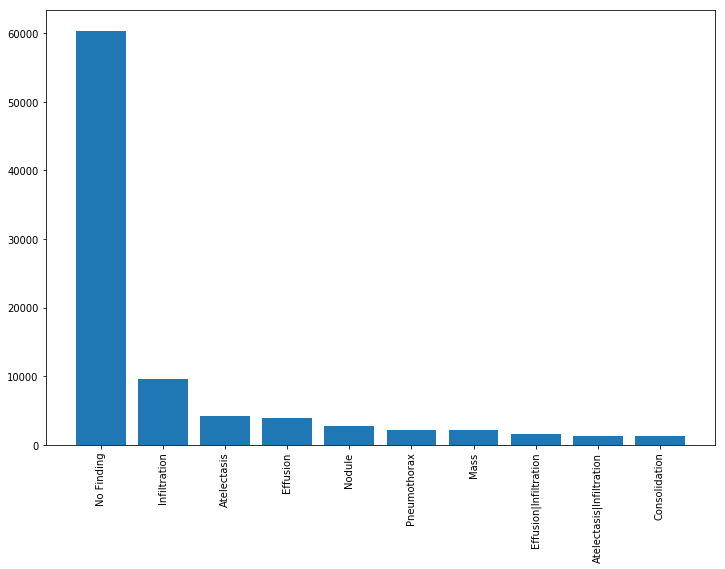

In [3]:
# only 10 top combinations of dicease
label_counts = all_xray_df['Finding Labels'].value_counts()[:10]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [4]:
# all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_xray_df['Finding Labels List'] = all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist()

In [5]:
all_labels = ['No Finding',
    'Atelectasis',
     'Cardiomegaly',
     'Consolidation',
     'Edema',
     'Effusion',
     'Emphysema',
     'Infiltration',
     'Mass'
    ]

In [6]:
all_xray_df.iloc[0,:]

Image Index                                           00000001_000.png
Finding Labels                                            Cardiomegaly
Follow-up #                                                          0
Patient ID                                                           1
Patient Age                                                         58
Patient Gender                                                       M
View Position                                                       PA
OriginalImage[Width                                               2682
Height]                                                           2749
OriginalImagePixelSpacing[x                                      0.143
y]                                                               0.143
Unnamed: 11                                                        NaN
path                           data\images_001\images\00000001_000.png
Finding Labels List                                     [Cardiomegaly]
Name: 

# data generator

In [7]:
from sklearn.model_selection import train_test_split

# all_xray_df_reset = all_xray_df.reset_index()

train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 1,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
                                    # dirty hack for keeping values with approximately the same proportion

test_df, val_df = train_test_split(test_df, 
                                   test_size = 0.25, 
                                   random_state = 1,
                                   stratify = test_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'test', test_df.shape[0], 'val', val_df.shape[0])

train 84090 test 21022 val 7008


In [8]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [50]:
all_labels = ['No Finding',
    'Atelectasis',
     'Cardiomegaly',
     'Consolidation',
     'Edema',
     'Effusion',
     'Emphysema',
     'Infiltration',
     'Mass'
    ]

train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=62,
    classes=all_labels
)


val_gen = core_idg.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=62,
    classes=all_labels
)


test_gen = core_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='Finding Labels List',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode="categorical",
    batch_size=62,
    classes=all_labels
)

Found 78261 images belonging to 9 classes.
Found 6516 images belonging to 9 classes.
Found 19566 images belonging to 9 classes.


In [51]:
78261/62

1262.274193548387

In [10]:
a = next(train_gen)

In [11]:
train_gen.reset()

In [12]:
a[0].shape

(228, 224, 224, 1)

In [13]:
# make sure that encoding is right
print(a[1].sum(axis=1))
a[1]

[1. 1. 1. 1. 6. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 2. 3. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 3.
 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 2. 1. 1. 2.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 3. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1.]


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

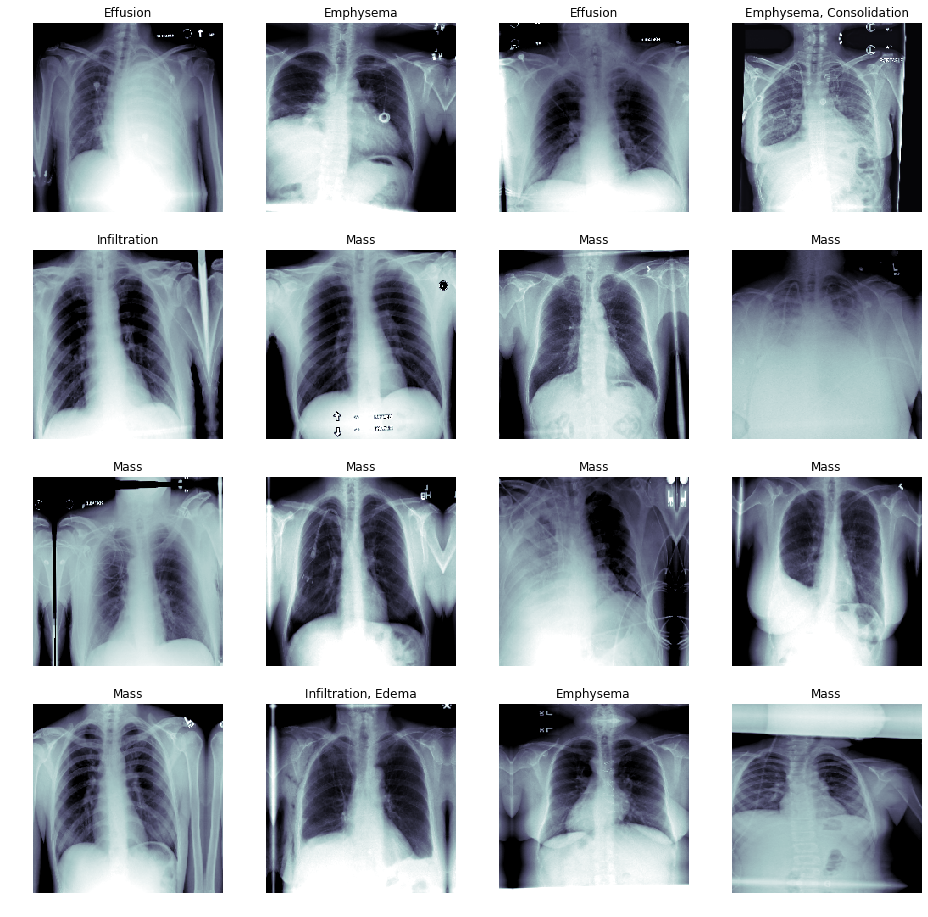

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(train_gen.class_indices.keys(), c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


In [15]:
train_gen.reset()

In [16]:
total = all_xray_df.shape[0]

class_weights = {}

for key in train_gen.class_indices.keys():
    amount = all_xray_df['Finding Labels List'].map(lambda x: key in x).sum()
    class_number = train_gen.class_indices[key]
    class_weights [class_number] = total/amount

In [17]:
class_weights
# those will be passed to balance the model treating of different classes

{0: 9.699801020849554,
 1: 40.389048991354464,
 2: 24.023998285836726,
 3: 48.68432479374729,
 4: 8.419313659232559,
 5: 44.56279809220986,
 6: 5.6358701115914345,
 7: 19.39121411276375,
 8: 1.8574907639038452}

# model creation

In [18]:
t_x.shape[1:]

(224, 224, 1)

In [19]:
from keras.applications.resnet50 import ResNet50


from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D
from keras.models import Sequential


base_ResNet50= ResNet50(include_top = False, weights = 'imagenet')

C:\Users\Shahab\Anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
multi_disease_model = Sequential()

In [21]:
'''
Freezed conv layer which produces the same image with 3 channels
'''
convol_same = Conv2D(trainable=False, input_shape=t_x.shape[1:], filters=3, kernel_size=(1, 1), strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='ones', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

In [22]:
multi_disease_model.add(convol_same)

In [23]:
multi_disease_model.add(base_ResNet50)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                

In [24]:
with open('multi_disease_model_resnet.json', 'w') as f:
    f.write(multi_disease_model.to_json())

In [25]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
#weight_path="{}_weights.best.hdf5".format('xray_class')
weight_path='resnet_imagenet.{epoch:03d}-{val_loss:.3f}.hdf5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",  mode="min", patience=7)

tb = TensorBoard(log_dir = 'tb_resnet50')

callbacks_list = [checkpoint, early, tb]

In [52]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=1262,
                                  validation_data = val_gen, 
                                  validation_steps = 3,
                                  epochs = 30, 
                                  class_weight = class_weights,
                                  callbacks = callbacks_list)

Epoch 1/30
1262/1262 [==============================] - 1844s 1s/step - loss: 2.9828 - binary_accuracy: 0.8695 - mean_absolute_error: 0.2242 - val_loss: 0.3254 - val_binary_accuracy: 0.8799 - val_mean_absolute_error: 0.2159

Epoch 00001: val_loss improved from 0.35469 to 0.32542, saving model to resnet_imagenet.001-0.325.hdf5
Epoch 2/30
1262/1262 [==============================] - 1788s 1s/step - loss: 2.9689 - binary_accuracy: 0.8699 - mean_absolute_error: 0.2228 - val_loss: 0.4151 - val_binary_accuracy: 0.8787 - val_mean_absolute_error: 0.1576

Epoch 00002: val_loss did not improve from 0.32542
Epoch 3/30
 181/1262 [===>..........................] - ETA: 24:51 - loss: 2.9627 - binary_accuracy: 0.8702 - mean_absolute_error: 0.2233

KeyboardInterrupt: 

In [53]:
multi_disease_model.save_weights('resnet_final_2try.h5')

------------------------

In [57]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('multi_disease_model_resnet.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('resnet_final_2try.h5')

In [58]:
def to_01(classes):
    size = len(classes)
    y = np.zeros((size, 9))
    for i in range(size):
        for j in classes[i]:
            y[i,j] = 1
    return y

test_y = to_01(test_gen.classes)

In [60]:
from tqdm import tqdm
test_gen.reset()
batch_size = 62
steps = len(test_gen.classes)//batch_size

test_y_list = []
pred_y_list = []

for i in tqdm(range(steps)):
    test_X, test_y = next(test_gen)
    pred_y = model.predict(test_X)
    
    test_y_list.append(test_y)
    pred_y_list.append(pred_y)
    
test_y_all = np.concatenate(test_y_list)
pred_y_all = np.concatenate(pred_y_list)


 21%|█████████████████▏                                                               | 67/315 [05:35<07:14,  1.75s/it]


 43%|██████████████████████████████████▎                                             | 135/315 [07:34<05:09,  1.72s/it]


 64%|███████████████████████████████████████████████████▌                            | 203/315 [09:33<03:20,  1.79s/it]


 86%|████████████████████████████████████████████████████████████████████▊           | 271/315 [11:34<01:47,  2.45s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 315/315 [12:53<00:00,  1.73s/it]

In [61]:
pred_y_all[:10]

array([[9.78090689e-02, 1.05485417e-01, 1.83841139e-02, 1.22008685e-04,
        3.56000476e-02, 1.20608299e-03, 1.16952866e-01, 2.72408295e-02,
        7.62096524e-01],
       [2.03766093e-01, 4.34110463e-01, 4.52384576e-02, 3.54045397e-03,
        2.48084843e-01, 3.95710059e-02, 1.40471458e-01, 7.49262720e-02,
        2.12387487e-01],
       [1.76017225e-01, 2.23672956e-01, 3.28891091e-02, 2.42267968e-03,
        9.71971229e-02, 3.39492187e-02, 1.34274811e-01, 6.84870556e-02,
        3.48174751e-01],
       [7.27378502e-02, 9.30059776e-02, 4.06075418e-02, 9.29792970e-03,
        7.68371150e-02, 6.56001791e-02, 1.79521278e-01, 1.06219217e-01,
        3.39089572e-01],
       [4.45357300e-02, 3.97555269e-02, 7.34746084e-03, 8.73685131e-05,
        1.20242592e-02, 5.99935185e-03, 7.85360113e-02, 4.75960858e-02,
        7.55340695e-01],
       [1.43235996e-01, 9.36289281e-02, 1.49466366e-01, 1.89145178e-01,
        3.54686797e-01, 5.56053929e-02, 3.40785146e-01, 6.65231720e-02,
        4.3

In [62]:
import pickle
pred_y_pickle = open("prediction.pkl", 'wb')

pickle.dump(pred_y_all, pred_y_pickle)
pred_y_pickle.close()

test_y_pickle = open("test_true.pkl", 'wb')
pickle.dump(test_y_all, test_y_pickle)

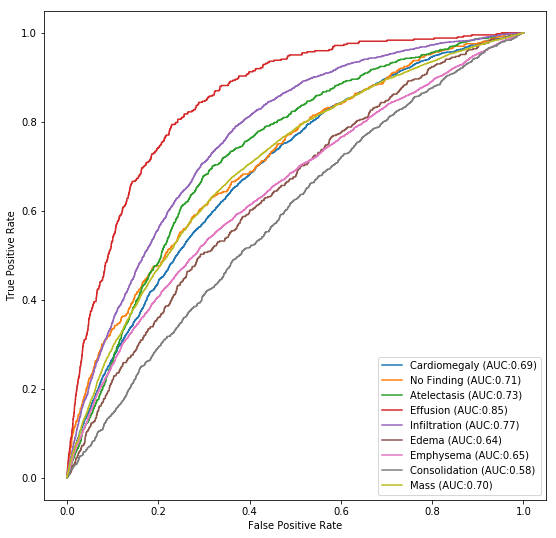

In [64]:
# building ROC curves

from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(train_gen.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve(test_y_all[:,idx].astype(int), pred_y_all[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('imagenet_trained_net_resnet.png')

-----